# Initial Setup

In [90]:
# Core libraries
import numpy as np
import random
import pandas as pd
import os
import time

# Plotting and visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Scikit-learn: models, kernels, metrics, and preprocessing
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

# Statistical and distance utilities
from scipy.spatial.distance import pdist
from scipy.stats import skew

# Model saving/loading
import joblib

# TensorFlow / Keras for neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [2]:
# Create output directories if they don't already exist
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Dataset Loading and Inspection

In [3]:
# Load individual simulation datasets
df1 = pd.read_csv('data/simulation_1_1100.csv')
df2 = pd.read_csv('data/simulation_2_699.csv')
df3 = pd.read_csv('data/simulation_3_1580.csv') 

# Combine all datasets into a single DataFrame
df = pd.concat([df1, df2, df3], ignore_index=True)

# Save the combined dataset to disk
df.to_csv('data/simulation_results.csv', index=False)

In [70]:
# General dataset metrics
print(f'The dataset shape is: {df.shape}')  # Prints number of rows and columns
print('\n')
print(f'The first five entries of the dataset: \n{df.head()}')  # Displays a preview of the dataset

# Calculate total simulation runtime in hours
total_seconds = df['runtime'].sum()
total_hours = total_seconds / 3600 
print(f"\nTotal simulation time: {total_seconds:.0f} seconds ({total_hours:.2f} hours)")

The dataset shape is: (3378, 7)


The first five entries of the dataset: 
         W1        W2         R         t  sigma_max       mass  runtime
0  0.453176  0.109103  0.050891  0.018525  33.511278  38.817408   22.156
1  0.545083  0.173166  0.049431  0.014302  57.556616  41.342222   26.774
2  0.511916  0.132664  0.043735  0.017039  42.156568  45.060976   24.496
3  0.521147  0.145586  0.056524  0.018902  36.736828  51.257317   24.262
4  0.448400  0.147370  0.051096  0.016280  47.511308  31.631060   19.959

Total simulation time: 81754 seconds (22.71 hours)


In [72]:
# Normalize the design variable inputs using Min-Max scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[['W1', 'W2', 'R', 't']])

# Compute pairwise distances for the Latin Hypercube Sampling (LHS) dataset
min_dist = np.min(pdist(X_scaled))
mean_dist = np.mean(pdist(X_scaled))
print(f"LHS Min distance: {min_dist:.4f}")
print(f"LHS Mean distance: {mean_dist:.4f}")

# Compare LHS spacing to uniform random sampling over multiple trials
n_trials = 100
min_dists = []
mean_dists = []

for _ in range(n_trials):
    rand_sample = np.random.rand(*X_scaled.shape)
    min_dists.append(np.min(pdist(rand_sample)))
    mean_dists.append(np.mean(pdist(rand_sample)))

# Compute average spacing metrics from the random sampling trials
avg_min_rand = np.mean(min_dists)
avg_mean_rand = np.mean(mean_dists)

print(f"\nRandom Sampling (avg. over {n_trials} trials):")
print(f" Avg. Min distance: {avg_min_rand:.4f}")
print(f" Avg. Mean distance: {avg_mean_rand:.4f}")


LHS Min distance: 0.0161
LHS Mean distance: 0.7737

Random Sampling (avg over 100 trials):
 Avg Min distance: 0.0127
 Avg Mean distance: 0.7778


# Gaussian Process Regression Model

## Data preparation:

In [73]:
# Shuffle the combined dataset to ensure a representative sample
df_combined = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use the first 400 samples for GPR kernel comparison
df_gpr_comparison = df_combined.iloc[:400]

# Extract input features and target variable (von Mises stress)
X = df_gpr_comparison[['W1', 'W2', 'R', 't']].values
Y = df_gpr_comparison['sigma_max'].values

# Normalize input features to [0, 1] range to improve GPR performance
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Cross-Validation and Kernel Choice

In [ ]:
# Define different kernel options for the GPR model
kernels = {
    "RBF": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
    "RBF + WhiteKernel": (C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1)),
    "Matern 32": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=1.5),
    "Matern 52": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=2.5),
    "RBF (alpha=1e-4)": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))
}

# Set up 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
kernel_results = {}

# Train and evaluate each kernel
for name, kernel in kernels.items():
    if name == "RBF (alpha=1e-4)":
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=15, normalize_y=True)
    else:
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)

    # Predict using cross-validation
    Y_pred = cross_val_predict(gpr, X_scaled, Y, cv=cv)
    
    # Calculate performance metrics
    r2 = r2_score(Y, Y_pred)
    mae = mean_absolute_error(Y, Y_pred)
    mape = mean_absolute_percentage_error(Y, Y_pred)

    # Store results
    kernel_results[name] = {
        "r2": r2,
        "mae": mae,
        "mape": mape
    }

    # Print metrics
    print(f"{name}:")
    print(f"R^2:  {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2%}")
    print()

# Manually find best kernel for each metric
best_r2 = None
best_mae = None
best_mape = None

highest_r2 = -float('inf')
lowest_mae = float('inf')
lowest_mape = float('inf')

for name, metrics in kernel_results.items():
    if metrics['r2'] > highest_r2:
        best_r2 = (name, metrics)
        highest_r2 = metrics['r2']
    if metrics['mae'] < lowest_mae:
        best_mae = (name, metrics)
        lowest_mae = metrics['mae']
    if metrics['mape'] < lowest_mape:
        best_mape = (name, metrics)
        lowest_mape = metrics['mape']

print("Summary of Best Kernels:")
print(f"Highest R^2:  {best_r2[0]} → {best_r2[1]['r2']:.4f}")
print(f"Lowest MAE: {best_mae[0]} → {best_mae[1]['mae']:.4f}")
print(f"Lowest MAPE: {best_mape[0]} → {best_mape[1]['mape']:.2%}")


In [126]:
# Set global font to Times New Roman for all plots
plt.rcParams["font.family"] = "Times New Roman"

# Define default text sizes for plots
labelsize = 16
titlesize = 18
legendsize = 14

comparison_labelsize = 19
comparison_titlesize = 28
comparison_legendsize = 18

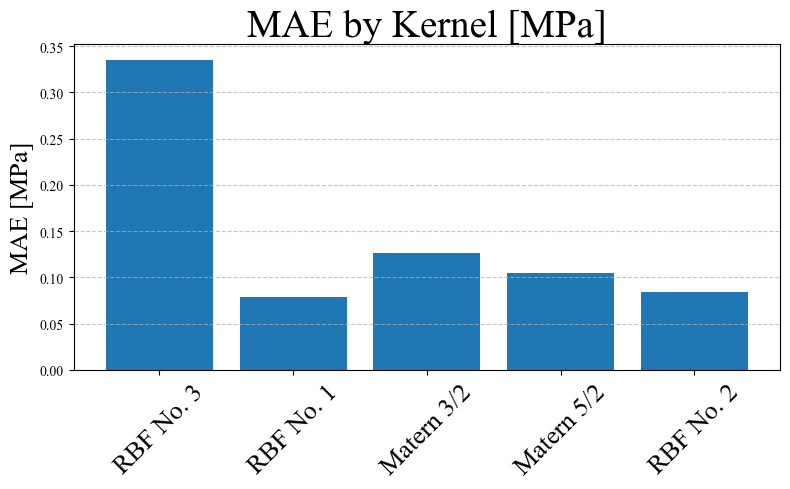

In [127]:
# Extract metrics from kernel results
kernel_names = list(kernel_results.keys())
maes = [kernel_results[k]['mae'] for k in kernel_names]
mapes = [kernel_results[k]['mape'] for k in kernel_names]
r2s = [kernel_results[k]['r2'] for k in kernel_names]

# Custom labels for bar plot
kernel_labels = ['RBF No. 3', 'RBF No. 1', 'Matern 3/2', 'Matern 5/2', 'RBF No. 2']

# Plot MAE for each kernel
plt.figure(figsize=(8, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar(kernel_labels, maes)
plt.xticks(fontsize=comparison_labelsize, rotation=45)
plt.ylabel("MAE [MPa]", fontsize=comparison_labelsize)
plt.title("MAE by Kernel [MPa]", fontsize=comparison_titlesize)
plt.tight_layout()
plt.savefig("figures/kernel_mae.png", dpi=600)
plt.show()

In [79]:
# Print out the results for each kernel
print("Results: \n")
for _ in range(len(kernel_names)):
    print("-----------------------")
    print(f"kernel: {kernel_labels[_]}, R_2 = {r2s[_]}, MAE = {maes[_]}, MAPE = {mapes[_]}")

Results: 

-----------------------
kernel: RBF No. 3, R_2 = 0.9982849173263657, MAE = 0.3350674943067781, MAPE = 0.006423681940203107
-----------------------
kernel: RBF No. 1, R_2 = 0.9999244850903535, MAE = 0.07914252210325114, MAPE = 0.001439082051866674
-----------------------
kernel: Matern 3/2, R_2 = 0.9996733984983392, MAE = 0.12613493423847832, MAPE = 0.0021592376884024527
-----------------------
kernel: Matern 5/2, R_2 = 0.9998616981024062, MAE = 0.10489870638688079, MAPE = 0.0019341525560461331
-----------------------
kernel: RBF No. 2, R_2 = 0.9999049813963866, MAE = 0.08364914148605823, MAPE = 0.0014992996763193405


## RBF + White Noise - determining the sample size

In [81]:
def evaluate_sample_efficiency(df, sample_sizes, repeats=15, eval_size=1000):
    # Extract inputs and outputs
    X_full = df[['W1', 'W2', 'R', 't']].values
    Y_full = df['sigma_max'].values
    time_full = df['runtime'].values

    # Split off a fixed evaluation set from the full dataset
    X_remain, X_eval, Y_remain, Y_eval, time_remain, _ = train_test_split(
        X_full, Y_full, time_full, test_size=eval_size, random_state=42
    )

    # Scale features using training data only
    scaler = MinMaxScaler()
    X_remain_scaled = scaler.fit_transform(X_remain)
    X_eval_scaled = scaler.transform(X_eval)

    # Define GPR kernel to be used throughout
    kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))

    # Prepare result containers
    mae_results = []
    mape_results = []
    time_results = []

    # Loop over sample sizes
    for n in sample_sizes:
        maes = []
        mapes = []
        total_time = 0.0

        # Create random train/test splits for each sample size
        splitter = ShuffleSplit(n_splits=repeats, train_size=n, random_state=42)
        print(f"Evaluating sample size: {n}")

        for train_indexes, _ in splitter.split(X_remain_scaled):
            # Get training subset
            X_train = X_remain_scaled[train_indexes]
            Y_train = Y_remain[train_indexes]
            time_train = time_remain[train_indexes]

            # Accumulate total simulation time
            total_time += np.sum(time_train)

            # Train GPR model and predict
            gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)
            gpr.fit(X_train, Y_train)
            Y_pred = gpr.predict(X_eval_scaled)

            # Store error metrics
            maes.append(mean_absolute_error(Y_eval, Y_pred))
            mapes.append(mean_absolute_percentage_error(Y_eval, Y_pred) * 100)  # in percent

        # Store averaged results for this sample size
        mae_results.append(np.mean(maes))
        mape_results.append(np.mean(mapes))
        time_results.append(total_time / repeats / 3600)  # convert to hours

    # Return results in dictionary format
    return {
        "sample_sizes": sample_sizes,
        "mae": mae_results,
        "mape": mape_results,
        "avg_sim_time": time_results
    }

In [39]:
# Measure runtime of the sample efficiency evaluation
start_time = time.time()
results = evaluate_sample_efficiency(df, sample_sizes=[100, 200, 300, 400, 500, 600, 800, 1000])
end_time = time.time()

# Calculate total runtime in seconds and hours
kernel_selection_runtime_s = end_time - start_time
kernel_selection_runtime_h = kernel_selection_runtime_s / 3600

# Print runtime summary
print(f"The total runtime for the cross validation was {kernel_selection_runtime_s:.4f} seconds or {kernel_selection_runtime_h:.4f} hours")


Evaluating sample size: 100


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 200


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Evaluating sample size: 300


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 400


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 500


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 600


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 800


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Evaluating sample size: 1000


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

The total runtime for the cross validation was 511.1206 seconds or 0.1420 hours


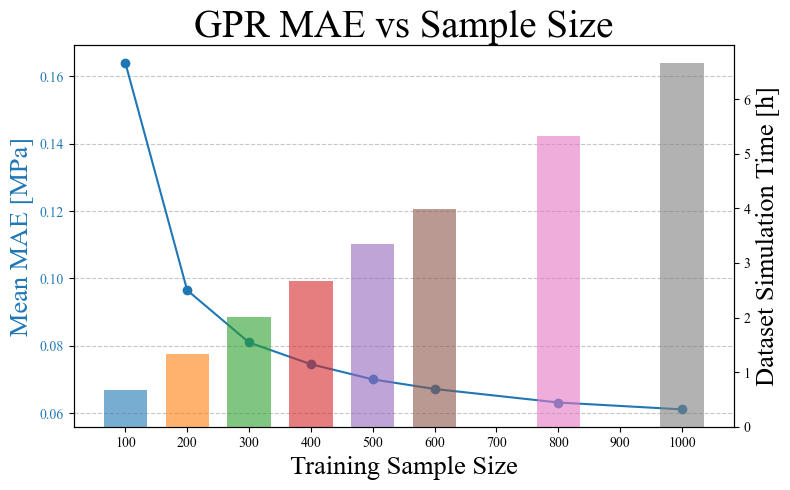

In [128]:
# Extract results
sample_sizes = results["sample_sizes"]
maes = results["mae"]
sim_times = results["avg_sim_time"]

# Set color map for bar chart
cmap = plt.colormaps['tab10']
colors = [cmap(i) for i in range(len(sample_sizes))]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 5))

# Line plot for MAE
ax1.plot(sample_sizes, maes, marker='o', color='tab:blue', label='Mean MAE')
ax1.set_xlabel("Training Sample Size", fontsize=comparison_labelsize)
ax1.set_ylabel("Mean MAE [MPa]", color='tab:blue', fontsize=comparison_labelsize)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(np.arange(0, max(sample_sizes) + 1, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar plot for average simulation time on a secondary y-axis
ax2 = ax1.twinx()
ax2.bar(sample_sizes, sim_times, width=70, color=colors, alpha=0.6, label='Avg. Sim Time')
ax2.set_ylabel("Dataset Simulation Time [h]", color='black', fontsize=comparison_labelsize)
ax2.tick_params(axis='y')

# Title and save
plt.title("GPR MAE vs Sample Size", fontsize=comparison_titlesize)
fig.tight_layout()
plt.savefig("figures/gpr_efficiency_combined.png", dpi=300)
plt.show()

In [87]:
# Print formatted summary table of GPR evaluation results
print("\n GPR Model Evaluation Summary")
print("\n")
print(f"{'Samples':>10} | {'MAE':>10} | {'MAPE (%)':>10} | {'Time (h)':>10}")
print("\n")

# Loop through and print each row of the results
for n, mae, mape, time in zip(results['sample_sizes'],
                              results['mae'],
                              results['mape'],
                              results['avg_sim_time']):
    print(f"{n:>10} | {mae:>10.4f} | {mape:>10.2f} | {time:>10.2f}")

print("\n")


 GPR Model Evaluation Summary


   Samples |        MAE |   MAPE (%) |   Time (h)


       100 |     0.1641 |       0.30 |       0.66
       200 |     0.0965 |       0.17 |       1.33
       300 |     0.0810 |       0.15 |       2.01
       400 |     0.0745 |       0.14 |       2.68
       500 |     0.0700 |       0.13 |       3.34
       600 |     0.0672 |       0.12 |       4.00
       800 |     0.0631 |       0.12 |       5.33
      1000 |     0.0611 |       0.11 |       6.65




# Final GPR Model Training:

In [91]:
# Start timing the final GPR training process
final_gpr_train_start = time.time()

# Set parameters and output directories
n_final_samples = 400
model_dir = "models"
data_dir = "data"

# Sample a subset of the dataset for final model training
df_final = df.sample(n=n_final_samples, random_state=42).reset_index(drop=True)
X = df_final[['W1', 'W2', 'R', 't']].values
Y = df_final['sigma_max'].values

# Normalize input features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define and train the GPR model
kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gpr.fit(X_scaled, Y)

# Save model, scaler, and training dataset
joblib.dump(gpr, f"{model_dir}/final_gpr_model.pkl")
joblib.dump(scaler, f"{model_dir}/final_scaler.pkl")
df_final.to_csv(f"{data_dir}/final_gpr_training_data.csv", index=False)

# Confirm save locations
print(f"Final GPR model and scaler saved to '{model_dir}/'")
print(f"Training dataset saved to '{data_dir}/final_gpr_training_data.csv'")


Final GPR model and scaler saved to 'models/'
Training dataset saved to 'data/final_gpr_training_data.csv'


# Final GPR Model Evaluation

In [92]:
# Load trained model, scaler, and training dataset

# Define file paths
model_path = f"models/final_gpr_model.pkl"
scaler_path = f"models/final_scaler.pkl"
train_data_path = f"data/final_gpr_training_data.csv"

# Load saved model and scaler
gpr = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Load training data
df_train = pd.read_csv(train_data_path)

# Create evaluation dataset from remaining unseen data
df_eval = df.drop(df_train.index, axis=0).reset_index(drop=True)

In [93]:
# Extract inputs and targets from evaluation set
X_eval = df_eval[['W1', 'W2', 'R', 't']].values
Y_eval = df_eval['sigma_max'].values
X_eval_scaled = scaler.transform(X_eval)

# Predict
Y_pred = gpr.predict(X_eval_scaled)

r2 = r2_score(Y_eval, Y_pred)
mae = mean_absolute_error(Y_eval, Y_pred)
mape = mean_absolute_percentage_error(Y_eval, Y_pred) * 100  # in %

print(f"Final GPR Evaluation:")
print(f"R² = {r2:.4f}")
print(f"MAE = {mae:.4f} MPa")
print(f"MAPE = {mape:.2f}%")

Final GPR Evaluation:
R² = 0.9999
MAE = 0.0724 MPa
MAPE = 0.14%


In [94]:
# Calculate residuals
residuals = Y_pred - Y_eval

# Compute and print mean residual
mean_residual = np.mean(residuals)
print(f"Mean Residual: {mean_residual:.4f} MPa")

# Measure skewness of the residual distribution
skewness = skew(residuals)
print(f"Residual Skewness: {skewness:.4f}")

# Calculate proportion of over- and underpredictions
prop_over = np.mean(residuals > 0)
prop_under = np.mean(residuals < 0)
print(f"Overpredictions: {prop_over*100:.1f}%")
print(f"Underpredictions: {prop_under*100:.1f}%")

Mean Residual: 0.0024 MPa
Residual Skewness: -3.2358
Overpredictions: 49.9%
Underpredictions: 50.1%


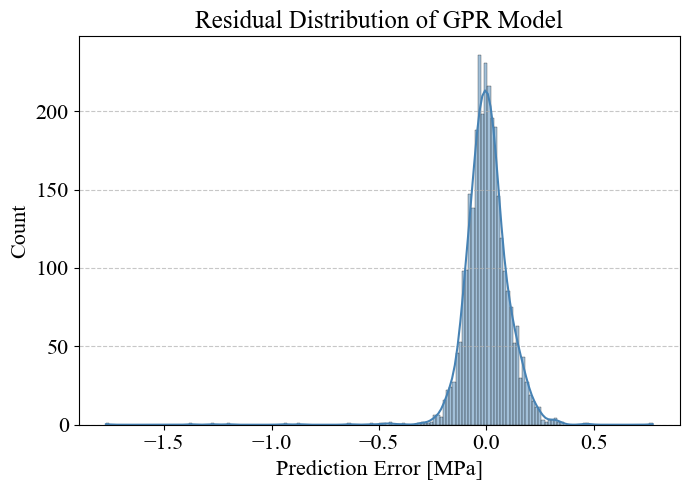

In [95]:
# Plot histogram of residuals with KDE overlay
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, color='steelblue')

# Add grid and axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Prediction Error [MPa]", fontsize=labelsize)
plt.ylabel("Count", fontsize=labelsize)

# Format tick labels
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)

# Set title and layout
plt.title("Residual Distribution of GPR Model", fontsize=titlesize)
plt.tight_layout()

# Save and show plot
plt.savefig("figures/final_gpr_residuals.png", dpi=600)
plt.show()

# Neural Network

# Keras Tuner Hyperparameter Search

In [96]:
# Prepare input and output data
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values

# Scale inputs and outputs using StandardScaler
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y.reshape(-1, 1))

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define a model-building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))

    # Add a tunable number of dense layers with tunable units and activation
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    
    # Output layer
    model.add(layers.Dense(1))

    # Compile with a tunable optimizer
    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# Initialize random search tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner",
    project_name="regression_model"
)

# Set up early stopping
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Retrieve the best-performing model
best_model = tuner.get_best_models(1)[0]

# Evaluate on the validation set
y_pred_scaled = best_model.predict(X_val)
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_val_true = output_scaler.inverse_transform(y_val)

# Compute and print evaluation metrics
mae = mean_absolute_error(y_val_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_true, y_pred))
print("Best model performance:")
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Trial 20 Complete [00h 00m 05s]
val_mae: 0.1601836234331131

Best val_mae So Far: 0.005675767082720995
Total elapsed time: 00h 13m 12s
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Best model performance:
MAE: 0.0819, RMSE: 0.1342


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [97]:
# Retrieve the best hyperparameter configuration from the search
best_trial = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter values
print("Best hyperparameters:")
for param in best_trial.values:
    print(f"{param}: {best_trial.get(param)}")

Best hyperparameters:
num_layers: 2
units_0: 32
activation: tanh
optimizer: adam
units_1: 80


# Well Tuned Neural Network

In [122]:
# Start timing the final neural network training
final_nn_start = time.time()

# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Extract features and target
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values.reshape(-1, 1)

# Split into training, validation, and test sets (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# Scale features and target values
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_val_scaled = output_scaler.transform(y_val)
y_test_scaled = output_scaler.transform(y_test)

# Build neural network using best hyperparameters from tuning
model = keras.Sequential([
    layers.Dense(96, activation='sigmoid', input_shape=(4,)),
    layers.Dense(16, activation='sigmoid'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Define callbacks for early stopping and learning rate reduction
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# Measure training duration
final_nn_end = time.time()
final_nn_runtime = final_nn_end - final_nn_start
print(f"The final runtime for the nn model was {final_nn_runtime:.4f} seconds")

# Save model, scalers, and test set
os.makedirs("models", exist_ok=True)
model.save("models/nn_model.keras")
joblib.dump(input_scaler, "models/nn_input_scaler.pkl")
joblib.dump(output_scaler, "models/nn_output_scaler.pkl")

df_test_save = pd.DataFrame(X_test, columns=['W1', 'W2', 'R', 't'])
df_test_save['sigma_max_true'] = y_test.flatten()
df_test_save.to_csv("data/nn_test_data.csv", index=False)

print("Model, dataset and scalers saved to 'models/' folder.")

Epoch 1/500


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9644 - mae: 0.7791 - val_loss: 0.7602 - val_mae: 0.6872 - learning_rate: 0.0010
Epoch 2/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6099 - mae: 0.6100 - val_loss: 0.3292 - val_mae: 0.4372 - learning_rate: 0.0010
Epoch 3/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2136 - mae: 0.3370 - val_loss: 0.0806 - val_mae: 0.1714 - learning_rate: 0.0010
Epoch 4/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0559 - mae: 0.1459 - val_loss: 0.0536 - val_mae: 0.1348 - learning_rate: 0.0010
Epoch 5/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.1310 - val_loss: 0.0471 - val_mae: 0.1263 - learning_rate: 0.0010
Epoch 6/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363 - mae: 0.1224 - val_loss: 0.0420 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 7/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321 - mae: 0.1152 - val_loss: 0.0379 - val_mae: 0.1124 - learning_rate: 0.0010
Epoch 8/500
74/74 ━━━━━━━

In [98]:
# Load trained neural network model and scalers
model = keras.models.load_model("models/nn_model.keras")
input_scaler = joblib.load("models/nn_input_scaler.pkl")
output_scaler = joblib.load("models/nn_output_scaler.pkl")
df_test = pd.read_csv("data/nn_test_data.csv")

# Prepare test data
X_test = df_test[['W1', 'W2', 'R', 't']].values
y_true = df_test['sigma_max_true'].values.reshape(-1, 1)
X_test_scaled = input_scaler.transform(X_test)

# Make predictions and inverse transform outputs
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Compute evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2:   {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE:  0.1135
RMSE: 0.1951
MAPE: 0.21%
R^2:   0.9998


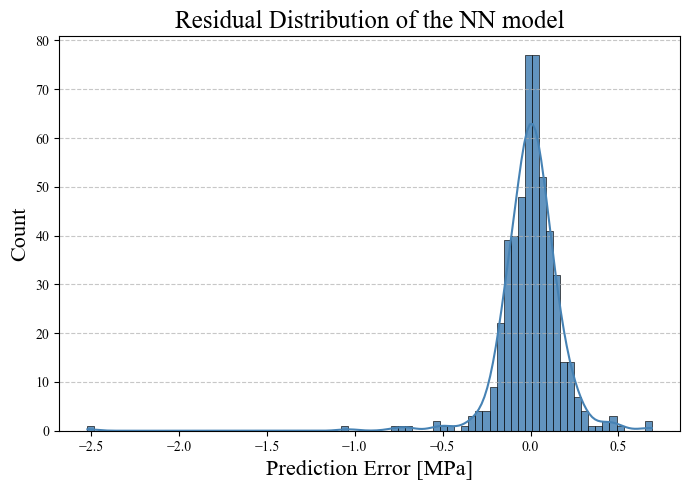

Mean Residual: -0.0018521525645360654 MPa
Residual Skewness: -4.6096519261726865
Overpredictions: 51.5%
Underpredictions: 48.5%


In [100]:
# Calculate residuals (prediction error)
residuals = y_pred.flatten() - y_true.flatten()

# Plot histogram of residuals with KDE overlay
plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, color='steelblue', alpha=0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Prediction Error [MPa]", fontsize=labelsize)
plt.ylabel("Count", fontsize=labelsize)
plt.title("Residual Distribution of the NN model", fontsize=titlesize)
plt.tight_layout()
plt.savefig("figures/nn_residuals.png", dpi=600)
plt.show()

# Compute basic statistics of the residuals
skewness = skew(residuals)
mean_res = np.mean(residuals)
percent_over = np.sum(residuals > 0) / len(residuals) * 100
percent_under = np.sum(residuals < 0) / len(residuals) * 100

# Print results
print(f"Mean Residual: {mean_res:} MPa")
print(f"Residual Skewness: {skewness:}")
print(f"Overpredictions: {percent_over:.1f}%")
print(f"Underpredictions: {percent_under:.1f}%")

# Time Calculations

In [101]:
# --- GPR ---
# Load training dataset used for GPR
gpr_training_dataset = pd.read_csv('data/gpr_training_data.csv')

# Define time costs for each stage (in seconds)
gpr_dataset_runtime_s = np.sum(gpr_training_dataset["runtime"])
gpr_pareto_front = 1.82 
final_gpr_training = 0.6
kernel_cross_validation = 541.10

# Store breakdown of steps
gpr_steps = {
    "Dataset Generation": gpr_dataset_runtime_s,
    "Kernel Cross-Validation": kernel_cross_validation,
    "Final Model Training": final_gpr_training,
    "Pareto Optimisation": gpr_pareto_front
}

# Calculate total runtime in seconds and hours
full_gpr_time_s = sum(gpr_steps.values())
full_gpr_time_h = full_gpr_time_s / 3600

# Print GPR runtime summary
print(f"\n--- GPR RUNTIME ---")
print(f"Total time: {full_gpr_time_s:.2f} s ({full_gpr_time_h:.2f} h)")
for name, t in gpr_steps.items():
    percent = 100 * t / full_gpr_time_s
    print(f"{name:<25}: {t:.2f} s ({percent:.1f}%)")

# --- NN ---
# Load test dataset used for NN
nn_test_dataset = pd.read_csv('data/nn_test_data.csv')

# Estimate training + validation dataset by excluding test data from full dataset
nn_training_dataset = pd.concat([df, nn_test_dataset, nn_test_dataset]).drop_duplicates(keep=False)

# Define time costs for each NN stage
nn_dataset_runtime = nn_training_dataset["runtime"].sum()
nn_pareto_front = 4.22
hyperparameter_search = 14 * 60  # 14 minutes in seconds
final_nn_training = 255.76 

# Store breakdown of steps
nn_steps = {
    "Dataset Generation": nn_dataset_runtime,
    "Hyperparameter Search": hyperparameter_search,
    "Final Model Training": final_nn_training,
    "Pareto Optimisation": nn_pareto_front
}

# Calculate total runtime in seconds and hours
full_nn_time_s = sum(nn_steps.values())
full_nn_time_h = full_nn_time_s / 3600

# Print NN runtime summary
print(f"\n--- NN RUNTIME ---")
print(f"Total time: {full_nn_time_s:.2f} s ({full_nn_time_h:.2f} h)")
for name, t in nn_steps.items():
    percent = 100 * t / full_nn_time_s
    print(f"{name:<25}: {t:.2f} s ({percent:.4f}%)")



--- GPR RUNTIME ---
Total time: 10485.10 s (2.91 h)
Dataset Generation       : 9941.58 s (94.8%)
Kernel Cross-Validation  : 541.10 s (5.2%)
Final Model Training     : 0.60 s (0.0%)
Pareto Optimisation      : 1.82 s (0.0%)

--- NN RUNTIME ---
Total time: 82854.31 s (23.02 h)
Dataset Generation       : 81754.33 s (98.6724%)
Hyperparameter Search    : 840.00 s (1.0138%)
Final Model Training     : 255.76 s (0.3087%)
Pareto Optimisation      : 4.22 s (0.0051%)


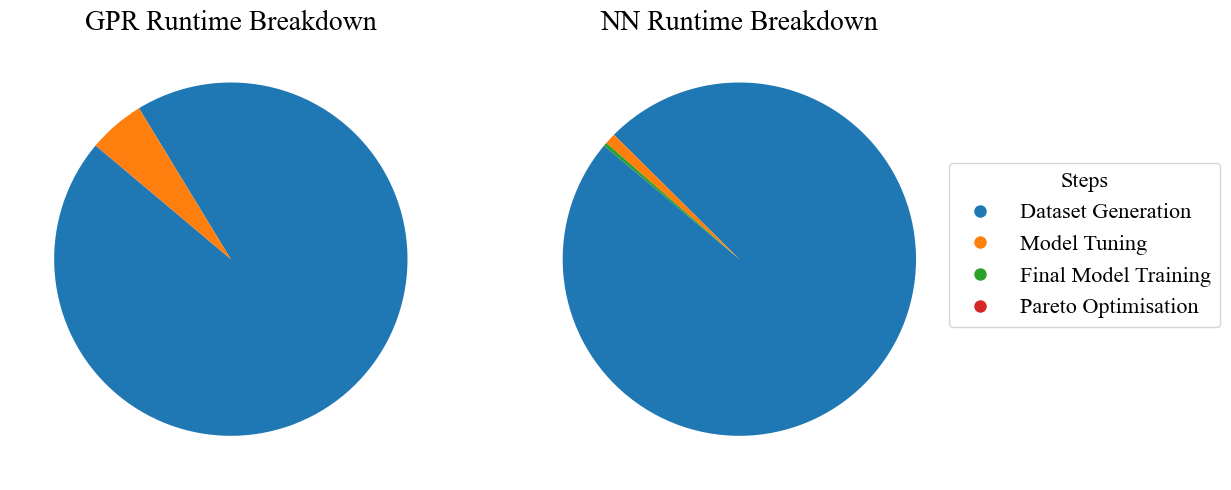

In [102]:
# --- Data ---
# Labels for each stage in the workflow
labels = ['Dataset Generation', 'Model Tuning', 'Final Model Training', 'Pareto Optimisation']

# Runtime breakdowns for GPR and NN
gpr_sizes = [gpr_dataset_runtime_s, kernel_cross_validation, final_gpr_training, gpr_pareto_front]
nn_sizes = [nn_dataset_runtime, hyperparameter_search, final_nn_training, nn_pareto_front]

# --- Plot ---
# Define text sizes for pie chart elements
piechart_labelsize = 18
piechart_titlesize = 20
piechart_legendsize = 16

# Create side-by-side pie charts
fig, axs = plt.subplots(1, 2, figsize=(13, 5))

# Select a color palette
colors = plt.get_cmap('tab10').colors[:len(labels)]

# GPR pie chart
axs[0].pie(gpr_sizes, labels=None, startangle=140, colors=colors)
axs[0].set_title("GPR Runtime Breakdown", fontsize=piechart_titlesize)

# NN pie chart
axs[1].pie(nn_sizes, labels=None, startangle=140, colors=colors)
axs[1].set_title("NN Runtime Breakdown", fontsize=piechart_titlesize)

# Create a shared legend
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=label, markerfacecolor=color, markersize=10)
           for label, color in zip(labels, colors)]

fig.legend(handles=handles, title="Steps", title_fontsize=piechart_legendsize, loc="center right", fontsize=piechart_legendsize)

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("figures/runtime_pies.png", dpi=300)
plt.show()

In [103]:
# Load test dataset and models
df_test = pd.read_csv("data/nn_test_data.csv")
X_test = df_test[['W1', 'W2', 'R', 't']].values

# Load scalers and models
input_scaler = joblib.load("models/nn_input_scaler.pkl")
output_scaler = joblib.load("models/nn_output_scaler.pkl")
gpr = joblib.load("models/final_gpr_model.pkl")
nn_model = keras.models.load_model("models/nn_model.keras")

# Scale first 100 test samples for timing
X_test_scaled = input_scaler.transform(X_test[:100])

# Calculate average FEA runtime across full dataset
avg_fea_time = df["runtime"].mean()

# Measure GPR prediction time per sample
start = time.time()
gpr.predict(X_test_scaled)
gpr_time = (time.time() - start) / len(X_test_scaled)

# Measure NN prediction time per sample
start = time.time()
nn_model.predict(X_test_scaled)
nn_time = (time.time() - start) / len(X_test_scaled)

# Calculate speedup relative to average FEA time
gpr_speedup = avg_fea_time / gpr_time
nn_speedup = avg_fea_time / nn_time

# Print results
print(f"Average FEA runtime: {avg_fea_time:.6f} s")
print(f"Average GPR prediction time: {gpr_time:.7f} s")
print(f"Average NN prediction time: {nn_time:.7f} s")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average FEA runtime: 24.201992 s
Average GPR prediction time: 0.0001065 s
Average NN prediction time: 0.0014458 s
